In [1]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
# from sentiment_analysis.makeDataset import *
from torch.utils.data import DataLoader, TensorDataset
import torch

import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../datasets/stock_news.csv')
# drop rows with stock == 'TMTG'
df = df[df['stock'] != 'TMTG']
df.head()

,stock,title,text,date,time,am_pm
0,AAPL,Morning Bid: Dollar surges after central bank ...,A look at the day ahead in U.S. and global mar...,2024-03-22,06:08,AM
1,AAPL,"Evercore says Apple sell-off is overdone, sees...",Apple (NASDAQ:AAPL) stock remains one of the v...,2024-03-11,16:54,PM
2,AAPL,US House passes bill to force ByteDance to div...,By David ShepardsonWASHINGTON (Reuters) -The U...,2024-03-13,06:01,AM
3,AAPL,"APPLE ALERT: Bragar Eagel & Squire, P.C. is In...","NEW YORK, March 22, 2024 (GLOBE NEWSWIRE) -- B...",2024-03-22,21:12,PM
4,AAPL,Apple have to find a way to settle potential D...,Following reports that the U.S. Department of ...,2024-03-21,09:04,AM


<Axes: xlabel='Sentiment', ylabel='Count'>

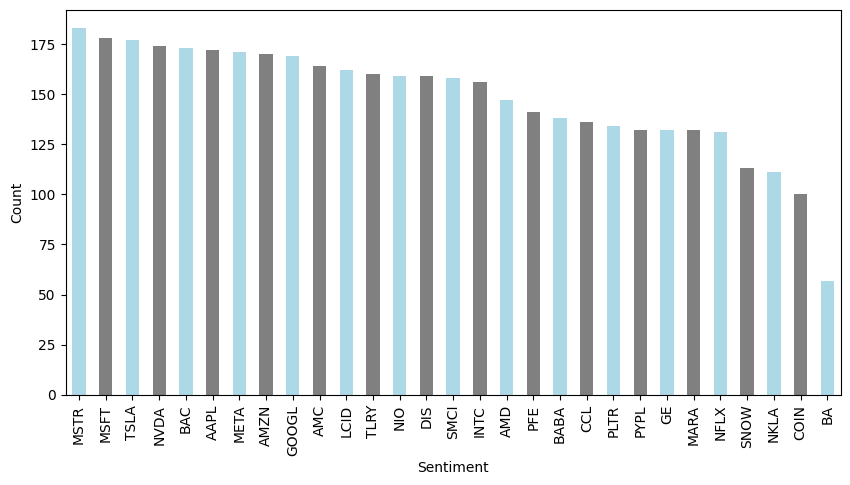

In [3]:
df.value_counts('stock').plot(kind='bar', 
                figsize=(10, 5), xlabel='Stock', ylabel='Count', color=['lightblue', 'gray'])


In [49]:
df = pd.read_csv('../datasets/stock_news.csv')
# drop rows with stock == 'TMTG'
df = df[df['stock'] != 'TMTG']
df.head()

,stock,title,text,date,time,am_pm
0,AAPL,Morning Bid: Dollar surges after central bank ...,A look at the day ahead in U.S. and global mar...,2024-03-22,06:08,AM
1,AAPL,"Evercore says Apple sell-off is overdone, sees...",Apple (NASDAQ:AAPL) stock remains one of the v...,2024-03-11,16:54,PM
2,AAPL,US House passes bill to force ByteDance to div...,By David ShepardsonWASHINGTON (Reuters) -The U...,2024-03-13,06:01,AM
3,AAPL,"APPLE ALERT: Bragar Eagel & Squire, P.C. is In...","NEW YORK, March 22, 2024 (GLOBE NEWSWIRE) -- B...",2024-03-22,21:12,PM
4,AAPL,Apple have to find a way to settle potential D...,Following reports that the U.S. Department of ...,2024-03-21,09:04,AM


In [50]:
min_dates = df.groupby('stock')['date'].min()
print("max:", max(min_dates), "- min:", min(min_dates))
news_df = df[df['date'] >= max(min_dates)]
unique_dates = news_df['date'].unique()
unique_stocks = news_df['stock'].unique()
print(unique_dates)
print(unique_stocks)

max: 2024-03-19 - min: 2020-11-04
['2024-03-22' '2024-03-21' '2024-03-28' '2024-03-25' '2024-03-29'
 '2024-03-19' '2024-03-26' '2024-03-20' '2024-03-27' '2024-03-24'
 '2024-03-23']
['AAPL' 'AMC' 'AMD' 'AMZN' 'BA' 'BABA' 'BAC' 'CCL' 'COIN' 'DIS' 'GE'
 'GOOGL' 'INTC' 'LCID' 'MARA' 'META' 'MSFT' 'MSTR' 'NFLX' 'NIO' 'NKLA'
 'NVDA' 'PFE' 'PLTR' 'PYPL' 'SMCI' 'SNOW' 'TLRY' 'TSLA']


In [57]:
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-tone', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained("../sentiment_analysis/saved_models/finbert_finetuned")
device = torch.device('cuda')
DEVICE = torch.device('cuda')
model = model.to(device)

batch_size = 16
mapper = {'negative': 0, 'neutral': 1, 'positive': 2}
reverse_mappers = {0: 'negative', 1: 'neutral', 2: 'positive'}

date_stock_dict = {}
for new_date in unique_dates:
    temp_df = news_df[news_df['date'] == new_date]
    stock_dict = {}
    for stock_name in unique_stocks:
        if stock_name in temp_df['stock'].values:
            stocks_in_one_day_title_x = temp_df[temp_df['stock'] == stock_name]['title']
            stocks_in_one_day_text_x = temp_df[temp_df['stock'] == stock_name]['text']
            stock_dict[stock_name] = (stocks_in_one_day_title_x, stocks_in_one_day_text_x)
    date_stock_dict[new_date] = stock_dict
new_title_list = []
new_text_list = []
for date, stock_dict in date_stock_dict.items():
    for stock_name, (title_x, text_x) in stock_dict.items():
        new_title_list.extend(list(title_x))
        new_text_list.extend((text_x))
x = np.array(new_title_list)
x2 = np.array(new_text_list)

In [59]:
test_dataset = CustomDataset(x, None, tokenizer, max_len=32)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_dataset2 = CustomDataset(x2, None, tokenizer, max_len=512)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=False)

model.eval()
title_predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        temp_list = [int(each) for each in predicted.cpu().numpy()]
        for each in temp_list:
            title_predictions.append(reverse_mappers[each])

model.eval()
text_predictions = []
with torch.no_grad():
    for batch in test_loader2:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        temp_list = [int(each) for each in predicted.cpu().numpy()]
        for each in temp_list:
            text_predictions.append(reverse_mappers[each])
torch.cuda.empty_cache()
import gc
gc.collect()

953

In [60]:
# load the model
model2 = DistilBertForSequenceClassification.from_pretrained("../sentiment_analysis/saved_models/flair_model")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Predict sentiment for x
x_encodings = tokenizer(list(x), truncation=True, padding=True, max_length=32)
x_dataset = TensorDataset(
    torch.tensor(x_encodings['input_ids']),
    torch.tensor(x_encodings['attention_mask'])
)
x_dataloader = DataLoader(x_dataset, batch_size=batch_size)
x_predictions = []
model2.eval()
for batch in x_dataloader:
    input_ids, attention_mask = batch
    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    model2 = model2.to(DEVICE)
    with torch.no_grad():
        outputs = model2(input_ids, attention_mask=attention_mask)
    predicted_labels = torch.argmax(outputs.logits, dim=1)
    x_predictions.extend(predicted_labels.tolist())

# Predict sentiment for x2
x2_encodings = tokenizer(list(x2), truncation=True, padding=True, max_length=512)
x2_dataset = TensorDataset(
    torch.tensor(x2_encodings['input_ids']),
    torch.tensor(x2_encodings['attention_mask'])
)
x2_dataloader = DataLoader(x2_dataset, batch_size=batch_size)
x2_predictions = []
model2.eval()
for batch in x2_dataloader:
    input_ids, attention_mask = batch
    input_ids = input_ids.to(DEVICE)
    attention_mask = attention_mask.to(DEVICE)
    model2 = model2.to(DEVICE)
    with torch.no_grad():
        outputs = model2(input_ids, attention_mask=attention_mask)
    predicted_labels = torch.argmax(outputs.logits, dim=1)
    x2_predictions.extend(predicted_labels.tolist())

# Map sentiment index to labels
sentiment_labels = {0: 'negative', 1: 'neutral', 2: 'positive'}

# Print the predictions with real labels
title_sentiment_list = []
for sentiment in x_predictions:
    title_sentiment_list.append(sentiment_labels[sentiment])

text_sentiment_list = []
for sentiment in x2_predictions:
    text_sentiment_list.append(sentiment_labels[sentiment])

In [79]:
def get_majority_vote(vote_dict):
    new_dict = {}
    for stock_name, votes in vote_dict.items():
        negative = votes['negative']
        positive = votes['positive']
        if negative == positive and negative == 0:
            max_voter = 0
        else:
            if negative > positive:
                max_voter = -1
            else:
                max_voter = 1
        new_dict[stock_name] = max_voter
    return new_dict

In [80]:
final_dict = {}
for i, (date, stock_dict) in enumerate(date_stock_dict.items()):
    sentiment_votes = {'positive': 0, 'neutral': 0, 'negative': 0}
    temp_dict = {}
    for j, (stock_name, (title_x, text_x)) in enumerate(stock_dict.items()):
        finbert_title_sentiment = title_predictions[i * len(unique_dates) + j]
        finbert_text_sentiment = text_predictions[i * len(unique_dates) + j]
        flair_title_sentiment = title_sentiment_list[i * len(unique_dates) + j]
        flair_text_sentiment = text_sentiment_list[i * len(unique_dates) + j]
        if stock_name not in temp_dict:
            temp_dict[stock_name] = {'positive': 0, 'neutral': 0, 'negative': 0}
        temp_dict[stock_name][finbert_title_sentiment] += 1
        temp_dict[stock_name][finbert_text_sentiment] += 1
        temp_dict[stock_name][flair_title_sentiment] += 1
        temp_dict[stock_name][flair_text_sentiment] += 1
    votes_dict = get_majority_vote(temp_dict)
    final_dict[date] = votes_dict
print(final_dict)

{'2024-03-22': {'AAPL': -1, 'AMZN': 0, 'BABA': 0, 'BAC': 1, 'CCL': -1, 'COIN': 1, 'GOOGL': 1, 'META': 1, 'MSFT': -1, 'MSTR': -1, 'NIO': 1, 'NVDA': 1, 'PFE': 1, 'TSLA': 1}, '2024-03-21': {'AAPL': 1, 'AMZN': 1, 'BA': 1, 'BABA': 0, 'BAC': -1, 'COIN': 1, 'DIS': 1, 'GOOGL': 1, 'INTC': 1, 'META': -1, 'MSFT': 1, 'MSTR': 1, 'NKLA': -1, 'NVDA': -1, 'SMCI': 0, 'SNOW': 0, 'TSLA': 0}, '2024-03-28': {'AAPL': 1, 'AMC': -1, 'AMZN': -1, 'BA': 0, 'BABA': 0, 'BAC': 0, 'CCL': 0, 'COIN': -1, 'DIS': 1, 'GE': 1, 'GOOGL': 1, 'INTC': -1, 'META': 1, 'MSFT': 1, 'MSTR': -1, 'NVDA': 1, 'PLTR': 1, 'PYPL': 1, 'SMCI': 1, 'SNOW': -1, 'TLRY': -1, 'TSLA': -1}, '2024-03-25': {'AAPL': -1, 'AMD': 1, 'AMZN': 1, 'BA': -1, 'BAC': 1, 'CCL': 1, 'COIN': 1, 'DIS': 1, 'GOOGL': -1, 'INTC': -1, 'LCID': -1, 'MARA': 1, 'META': 0, 'MSFT': -1, 'MSTR': 0, 'NFLX': -1, 'NIO': 0, 'NVDA': -1, 'PFE': 1, 'SMCI': 1, 'SNOW': -1, 'TSLA': -1}, '2024-03-29': {'AAPL': 1, 'AMZN': 0, 'BA': -1, 'COIN': 0, 'META': -1, 'MSFT': 0, 'MSTR': -1, 'NVDA': 1, 

In [84]:
final_df = pd.DataFrame(final_dict)
final_df2 = final_df.fillna(0)
final_df2.to_csv('../datasets/final_sentiment.csv')